#  wykrywanie spamu

`Oprogramowanie do wykrywania spamu`, znane również jako filtr antyspamowy, działa na serwerze pocztowym lub naszym komputerze i sprawdza skrzynkę odbiorczą w celu wykrycia potencjalnych wiadomości spamowych. Podobnie jak w przypadku tradycyjnych skrzynek pocztowych, skrzynka odbiorcza jest miejscem docelowym wiadomości e-mail. Detektor spamu ma zazwyczaj swobodny dostęp do tej skrzynki i może codziennie przeprowadzać dziesiątki, setki, a nawet tysiące kontroli, aby zdecydować, czy przychodząca wiadomość e-mail jest spamem, czy nie. Na szczęście wykrywanie spamu jest wszechobecną technologią, która filtruje nieistotną i potencjalnie niebezpieczną korespondencję elektroniczną.

W tym ćwiczeniu od podstaw wdrożymy program do wykrywania spamu i przedstawimy różne techniki związane z przetwarzaniem języka naturalnego.

Będziemy używać podzbioru podanego zbioru wiadomości e-mail dostępnego tutaj: <https://spamassassin.apache.org/old/publiccorpus/>

In [47]:
import sys
import subprocess
%pip install setuptools
import pkg_resources 

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'matplotlib', 'wordcloud', 'scikit-learn', 'nltk'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)

Note: you may need to restart the kernel to use updated packages.


## Chmury wyrazów

W procesie tworzenia filtra antyspamowego możemy przeanalizować treść wiadomości i sprawdzić, czy niektóre słowa pojawiają się częściej? Intuicyjnie, takie słowa mogą służyć do oddzielenia dwóch typów wiadomości e-mail. Łatwym sposobem wykonania tego zadania jest wizualizacja treści wiadomości za pomocą chmur wyrazów. W tej technice wizualizacji często występujące słowa w zbiorze danych (z wyłączeniem wyrazów funkcyjnych, zaimków i kilku innych przypadków) pojawiają się jako większe niż te rzadkie.

Jedną z możliwych implementacji chmur wyrazów w Pythonie jest biblioteka [word_cloud module](https://github.com/amueller/word_cloud).

(-0.5, 399.5, 199.5, -0.5)

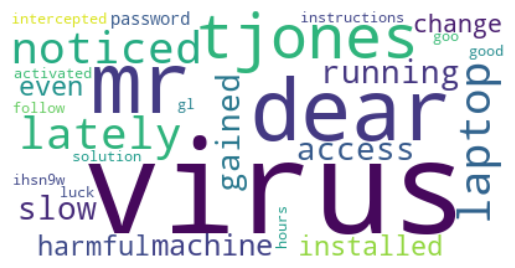

In [48]:
%matplotlib inline
# Import the necessary modules.
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Read the text from the file spam.txt.
text = open('./data/spam.txt').read()

# Create and configure the word cloud object.
wc = WordCloud(background_color="white", max_words=2000)

# Generate the word cloud image from the text.
wordcloud = wc.generate(text.lower())

# Display the generated image.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Na obrazie widać, że najczęstszym słowem w naszej wiadomości spamowej jest *"wirus"*.

Warto zauważyć, że techniki takie jak chmury wyrazów są powszechne w problemach uczenia maszynowego do eksploracji danych tekstowych przed zastosowaniem dowolnego rozwiązania. Proces ten nazywamy `analizą eksploracyjną danych` (EDA). EDA pozwala zrozumieć, w jaki sposób kierować dalszą analizą, a podstawowym narzędziem do tego zadania są metody wizualizacji.

## Usuwanie nieznaczących wyrazów

Częstym zadaniem podczas etapu preprocesingu jest usuwanie wszystkich słów, które prawdopodobnie pomagają nam skupić się na najważniejszych informacjach w tekście. Takie słowa nazywamy  `stop words` i nie istnieje ich uniwersalnej listy ani w języku angielskim, ani w żadnym innym języku.

(-0.5, 399.5, 199.5, -0.5)

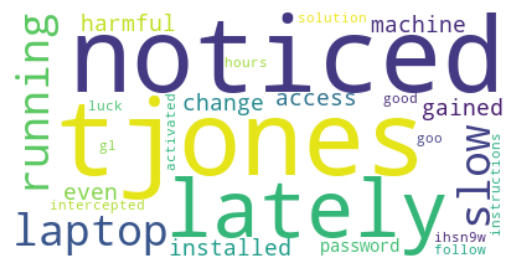

In [49]:
from wordcloud import WordCloud, STOPWORDS

# Read the text from the file data.txt.
text = open('./data/spam.txt').read()

# Get all stopwords and update with few others.
sw = set(STOPWORDS) 
sw.update(["dear", "virus", "mr"])

# Create and configure the word cloud object.
wc = WordCloud(background_color="white", stopwords=sw, max_words=2000)

# Generate the word cloud image from the text.
wordcloud = wc.generate(text.lower())

# Display the generated image.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Klasyfikacja

[Publiczny zbiór wiadomości email programu Apache SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/)  to wybór wiadomości email odpowiednich do opracowywania systemów filtrowania spamu. Oferuje on wiadomości w dwóch wariantach: czysty tekst lub format HTML. Dla uproszczenia w tym ćwiczeniu będziemy używać tylko pierwszego typu.

Terminem określającym przeciwieństwo wiadomości spamowych jest "ham" (szynka), ponieważ oba słowa są związane z produktami mięsnymi (spam odnosi się do konserwowej szynki). W tym ćwiczeniu korzystamy z podzbioru zbioru wiadomości.

Na początku czytamy wiadomości dla obu kategorii (ham i spam) i dzielimy je na grupy treningowe i testowe. Zasadniczo możemy wybrać podział 75:25 między dwoma zestawami, przypisując większą część danym treningowym.

In [50]:
import email
import glob
import numpy as np
from operator import is_not
from functools import partial
from sklearn.model_selection import train_test_split

# Load the path for each email file for both categories.
ham_files = train_test_split(glob.glob('./data/20030228_hard_ham/hard_ham/*'), random_state=123)
spam_files = train_test_split(glob.glob('./data/20050311_spam_2/spam_2/*'), random_state=123)

# Method for getting the content of an email.
def get_content(filepath):
    file = open(filepath, encoding='latin1')
    message = email.message_from_file(file)
    
    for msg_part in message.walk():
        # Keep only messages with text/plain content.
        if msg_part.get_content_type() == 'text/plain':
            return msg_part.get_payload()

# Get the training and testing data.
ham_train_data = [get_content(i) for i in ham_files[0]]
ham_test_data = [get_content(i) for i in ham_files[1]]
spam_train_data = [get_content(i) for i in spam_files[0]]
spam_test_data = [get_content(i) for i in spam_files[1]]

# Keep emails with non-empty content.
ham_train_data = list(filter(None, ham_train_data))
ham_test_data = list(filter(None, ham_test_data))
spam_train_data = list(filter(None, spam_train_data))
spam_test_data = list(filter(None, spam_test_data))

# Merge the train/test files for both categories.
train_data = np.concatenate((ham_train_data, spam_train_data))
test_data = np.concatenate((ham_test_data, spam_test_data))

# Assign a class for each email (ham = 0, spam = 1).
ham_train_class = [0]*len(ham_train_data)
ham_test_class = [0]*len(ham_test_data)
spam_train_class = [1]*len(spam_train_data)
spam_test_class = [1]*len(spam_test_data)

# Merge the train/test classes for both categories.
train_class = np.concatenate((ham_train_class, spam_train_class))
test_class = np.concatenate((ham_test_class, spam_test_class))

Następnym krokiem jest preprocessowanie danych przy użyciu poznanych wcześniej technik. W poniższym kodzie usuwamy wszystkie słowa funkcyjne.

In [51]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Tokenize the train/test data.
train_data = [word_tokenize(i) for i in train_data]
test_data = [word_tokenize(i) for i in test_data]


# Method for removing the stop words.
def remove_stop_words(input):
    result = [i for i in input if i not in ENGLISH_STOP_WORDS]
    return result

# Remove the stop words.
train_data = [remove_stop_words(i) for i in train_data]
test_data = [remove_stop_words(i) for i in test_data]

Teraz lematyzujemy słowa.

In [52]:
# Create the lemmatizer.
lemmatizer = WordNetLemmatizer()

# Method for lemmatizing the text.
def lemmatize_text(input):
    return [lemmatizer.lemmatize(i) for i in input]

# Lemmatize the text.
train_data = [lemmatize_text(i) for i in train_data]
test_data = [lemmatize_text(i) for i in test_data]

# Reconstruct the data.
train_data = [" ".join(i) for i in train_data]
test_data = [" ".join(i) for i in test_data]

Kontynuujemy ekstrakcją cech dla każdego zdania w obu zestawach. Ten krok wykorzystuje wektorizację tf-idf, po uprzednim wtrenowaniu wektoryzera na danych treningowych.

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the vectorizer.
vectorizer = TfidfVectorizer()

# Fit with the train data.
vectorizer.fit(train_data)

# Transform the test/train data into features.
train_data_features = vectorizer.transform(train_data)
test_data_features = vectorizer.transform(test_data)

Każda z *670* wiadomości email w zestawie treningowym jest reprezentowana przez wektor cech o rozmiarze *28337*.

In [54]:
print(train_data_features.shape)

(670, 28337)


## Maszyny wektorów nośnych(SVM)

Jednym z najbardziej znanych algorytmów uczenia maszynowego nadzorowanego jest algorytm `Support Vector Machines` – maszyny wektorów nośnych.

Oceniamy jego wydajność zarówno w zestawie testowym, jak i treningowym. Głównie interesuje nas pierwszy wynik, ponieważ on mierzy dokładność naszego modelu na nieznanych danych; mówiąc inaczej, jak dobrze generalizuje on wiedzę. Z drugiej strony, wyniki na zestawie treningowym wskazują, jak dobrze nasz model nauczył się z danych treningowych. Jak możesz zauważyć, dokładność w tym drugim przypadku nie zawsze wynosi *100%*, czego można by się spodziewać. W praktycznych zastosowaniach prawie zawsze jest znacznie niższa niż *99%*.

In [55]:
from sklearn import svm

# Create the classifier.
svm_classifier = svm.SVC(kernel="rbf", C=1.0, gamma=1.0, probability=True)

# Fit the classifier with the train data.
svm_classifier.fit(train_data_features.toarray(), train_class)

# Get the classification score of the train data.
svm_classifier.score(train_data_features.toarray(), train_class)

0.9970149253731343

Teraz wykorzystujemy zestaw testowy.

In [56]:
# Get the classification score of the test data.
svm_classifier.score(test_data_features.toarray(), test_class)

0.8755760368663594

## Naïve Bayes

`Naïve Bayes` jest algorytmem klasyfikacji opartym na `twierdzeniu Bayes'a`.

Podobnie jak w przypadku SVM, włączenie Naive Bayes jest stosunkowo proste.

In [57]:
from sklearn import naive_bayes

# Create the classifier.
nb_classifier = naive_bayes.MultinomialNB(alpha=1.0)

# Fit the classifier with the train data.
nb_classifier.fit(train_data_features.toarray(), train_class)

# Get the classification score of the train data.
nb_classifier.score(train_data_features.toarray(), train_class)

0.8641791044776119

Następnie wykorzystujemy zestaw testowy.

In [58]:
# Get the classification score of the test data.
nb_classifier.score(test_data_features.toarray(), test_class)

0.8571428571428571

Wyniki sugerują, że wydajność tego klasyfikatora jest niższa. Zwróć również uwagę na wynik na faktycznym zestawie treningowym, który jest niski i bardzo bliski wydajności na zestawie testowym.

## Dokładność

Standardowym podejściem w każdym problemie uczenia maszynowego jest wykorzystanie różnych algorytmów klasyfikacji i sprawdzenie, który z nich działa najlepiej. Wcześniej zastosowaliśmy dwie metody klasyfikacji do problemu filtrowania spamu, ale nasza praca się jeszcze nie skończyła; musimy dokładniej ocenić ich wydajność.

`Dokładność` to procent prawidłowo sklasyfikowanych przykładów przez algorytm, dzielony przez całkowitą liczbę przykładów. Poniższy kod oblicza dokładność na tych samych danych; jego wartość jest identyczna z wartością z poprzedniej sekcji.

In [59]:
from sklearn import metrics
 
# Get the predicted classes.
test_class_pred = nb_classifier.predict(test_data_features.toarray())

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_class, test_class_pred)

0.8571428571428571

## Precision and Recall

`Precyzja` mówi nam o proporcji pozytywnych identyfikacji, które w rzeczywistości są poprawne, natomiast `Odwołanie` mówi nam o proporcji faktycznych elementów pozytywnych, które zostały prawidłowo zidentyfikowane.

In [60]:
# Calculate the precision on the test set.
metrics.precision_score(test_class, test_class_pred)

0.8564814814814815

In [61]:
# Calculate the recall on the test set.
metrics.recall_score(test_class, test_class_pred)

1.0

## F-score

`F-score`,  jest średnią harmoniczną precyzji i odwołania. Kiedy precyzja i odwołanie osiągają idealny wynik (równy *1*), F-score staje się równe *1*.

In [62]:
# Calculate the F-score on the test set.
metrics.f1_score(test_class, test_class_pred)

0.9226932668329177

## ROC i AUC

Kiedy klasyfikator zwraca dla każdej predykcji pewnego rodzaju wynik ufności, możemy zastosować inną technikę oceny wydajności, nazywaną krzywą `charakterystyki operacyjnej odbiornika` (ROC). Krzywa ROC jest wykresem graficznym, który pokazuje wydajność modelu przy wszystkich progach klasyfikacji. Zacieniony obszar na tych wykresach, nazywany `polem pod krzywą ROC` (AUC), jest związany z jakością naszego modelu; im większa jego powierzchnia, tym lepiej.

Następnie obliczymy krzywe ROC dla obu klasyfikatorów.

Text(0.5, 0.98, 'Porównanie krzywych ROC')

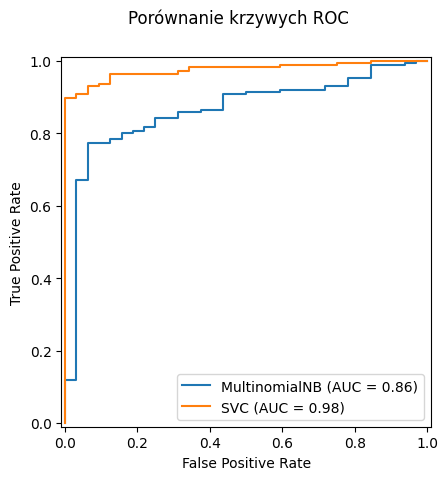

In [63]:
# Create a single figure and axis for the ROC plot
fig, ax = plt.subplots()

# Obtain the scores for each prediction.
probs = nb_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Compute the Receiver Operating Characteristic.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Utwórz pojedynczą figurę i oś dla wykresu ROC.
roc_auc = metrics.auc(fpr, tpr)

# Create the ROC curve.
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MultinomialNB').plot(ax=ax)

# Obtain the scores for each prediction.
probs = svm_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Compute the Receiver Operating Characteristic.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Compute Area Under the Curve.
roc_auc = metrics.auc(fpr, tpr)

# Create the ROC curve.
svm_disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='SVC').plot(ax=ax)

svm_disp.figure_.suptitle("Porównanie krzywych ROC")

Zgodnie z rysunkiem, wartość AUC dla SVM wynosi *0.98*, a dla Naive Bayes *0.87*. Wszystkie dotychczasowe wyniki potwierdzają nasze początkowe założenie o wyższości modelu SVM.

Na koniec obliczymy krzywą ROC wraz z `krzywą Precyzj Odwołania` dla modelu Naive Bayes.

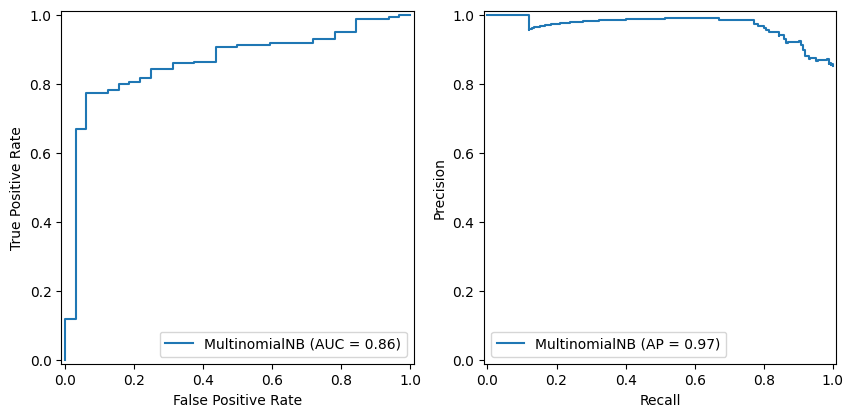

In [64]:
# Obtain the scores for each prediction.
probs = nb_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Compute the Receiver Operating Characteristic.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Compute Area Under the Curve.
roc_auc = metrics.auc(fpr, tpr)

# Create the ROC curve.
rc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MultinomialNB')

# Create the precision recall curves.
precision, recall, thresholds = metrics.precision_recall_curve(test_class, test_score)
ap = metrics.average_precision_score(test_class, test_score)
pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name='MultinomialNB')

# Plot the curves.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
rc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)

Oba wykresy podsumowują zależności między wskaźnikami na osi X i Y, wykorzystując różne progi prawdopodobieństwa. Na prawym wykresie średnia precyzja (AP) dla modelu Naive Bayes wynosi *0,97*.

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create the models.
model1 = LogisticRegression()
model2 = DecisionTreeClassifier()

# Train the models.
model1.fit(train_data_features.toarray(), train_class)
model2.fit(train_data_features.toarray(), train_class)

# Get the predictions for each model.
pred1 = model1.predict_proba(test_data_features.toarray())
pred2 = model2.predict_proba(test_data_features.toarray())
pred3 = svm_classifier.predict_proba(test_data_features.toarray())

# Calculate the final prediction as the average of the predictions from the three models.
final_pred = (pred1 + pred2 + pred3) / 3

# The final prediction is the class with the highest average probability.
final_pred = np.argmax(final_pred, axis=1)

# Calculate the accuracy of the hybrid model.
print("Accuracy of hybrid model: ", accuracy_score(test_class, final_pred))

Accuracy of hybrid model:  0.9447004608294931
